In [2]:
library(tidyverse,quietly = T)
library(caret,quietly = T)
library(AppliedPredictiveModeling,quietly = T)
library(Rtsne,quietly = T)
library(dplyr,quietly = T)
.libPaths("/root/R/x86_64-conda_cos6-linux-gnu-library/3.5")
library(cluster,quietly = T)
library(fpc,quietly = T)
library(caret,quietly = T)
require(randomForest,quietly = T)
library(ROCR,quietly = T)
library(reshape,quietly = T)
library(ggpubr,quietly = T)
library(gridExtra,quietly = T)

In [25]:
mccs_ess <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ess_mccs_data.csv",stringsAsFactors=FALSE)
dim(mccs_ess)
ess_siv_probs <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ESS_SIV_Probes.csv")
dim(ess_siv_probs)
table(mccs_ess$CancerCellType)
head(mccs_ess)

[1] 6926 3836

[1] 2210   31


    BC    CRC Kidney   Lung   MBCN     PC    UCC 
   866   1668    282    662    870   1726    852 

Sample,CancerCellType,AlcoholAmount,CaseControl,ID,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,cg27532845,cg27544046,cg27571329,cg27582696,cg27592331,cg27619291,cg27625491,cg27631256,cg27652490,cg27662789
Sample_1,BC,4,0,BC_Pair_1,0,0.08745385,29.20516,0.10727967,0.14815719,⋯,2.280988,2.795142,3.338043,0.2757069,-3.337371,NA,2.4544216,-4.468435,3.074308,1.5031854
Sample_2,BC,2,1,BC_Pair_1,0,0.10287884,27.96231,0.13150276,0.12602529,⋯,4.014220,1.086616,9.964341,NA,-4.822580,NA,0.8084884,-7.693036,4.349528,0.2663663
Sample_3,BC,2,1,BC_Pair_2,-1,0.09067746,21.87242,0.04251249,0.17096309,⋯,2.187318,2.341161,5.138541,1.6337358,-3.616787,NA,5.5207225,-4.831125,3.901991,-0.1687805
Sample_4,BC,2,0,BC_Pair_2,-1,0.10010919,23.83473,0.08627580,0.13397215,⋯,2.537392,2.546065,4.042145,-0.3903966,-4.159341,NA,2.8802368,-6.559135,3.913823,0.8703156
Sample_5,BC,2,0,BC_Pair_3,-1,0.08467049,23.55767,0.03608380,0.09226610,⋯,1.139770,3.296778,3.428133,5.1884724,-4.835844,NA,2.7962156,-3.413570,4.278615,-0.1579524
Sample_6,BC,2,1,BC_Pair_3,0,0.05459091,34.10303,0.05873613,0.06257519,⋯,1.908921,2.766869,3.602330,5.7284437,-3.555191,NA,2.9473541,-5.424312,3.678586,-0.3242363


In [128]:
plot_tSNE_CANCER_Case_Control <- function(CANCER_TYPE){
cancer_cases_controls <- mccs_ess[mccs_ess$CancerCellType==CANCER_TYPE,]
cancer_cases_control_methy<- cancer_cases_controls[,ess_siv_probs$CG]
dim(cancer_cases_control_methy)
nums <- unlist(lapply(cancer_cases_control_methy, is.numeric))
cancer_cases_control_methy <- cancer_cases_control_methy[,nums]
cancer_cases_control_methy <- cancer_cases_control_methy[ , colSums(is.na(cancer_cases_control_methy)) == 0]
dim(cancer_cases_control_methy)
#set.seed(9)
tsne_model_PC_case_control = Rtsne(as.matrix(cancer_cases_control_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
tsne_model_PC_case_control = as.data.frame(tsne_model_PC_case_control$Y)
tsne_model_PC_case_control$CaseControl <- as.factor(cancer_cases_controls$CaseControl)


merged <- ggplot(tsne_model_PC_case_control, aes(x=V1, y=V2,colour=CaseControl)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle(paste0(CANCER_TYPE, " Cases and Controls")) +
  scale_colour_brewer(palette = "Set2")
    
cases <- tsne_model_PC_case_control[tsne_model_PC_case_control$CaseControl==1,]
case <- ggplot(cases, aes(x=V1, y=V2)) +
  geom_point(size=0.45,color="red") +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("Cases") +
  scale_colour_brewer(palette = "Set2")
    
    
controls <- tsne_model_PC_case_control[tsne_model_PC_case_control$CaseControl==0,]
control <- ggplot(controls, aes(x=V1, y=V2)) +
  geom_point(size=0.45,color="blue") +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("Control") +
  scale_colour_brewer(palette = "Set2")
    
    tsne_model_PC_case_control$ID <- cancer_cases_controls$ID
    distances <- c()
    for (pair in unique(as.character(tsne_model_PC_case_control$ID))){
        pair_ID <- pair
        a <- as.numeric(tsne_model_PC_case_control[tsne_model_PC_case_control$ID==pair_ID,][1,c(1,2)])
        b <- as.numeric(tsne_model_PC_case_control[tsne_model_PC_case_control$ID==pair_ID,][2,c(1,2)])
        distances <- c(distances,dist(data.frame(a,b)))
    }
    
    return(list(merged,case,control,distances))
    }

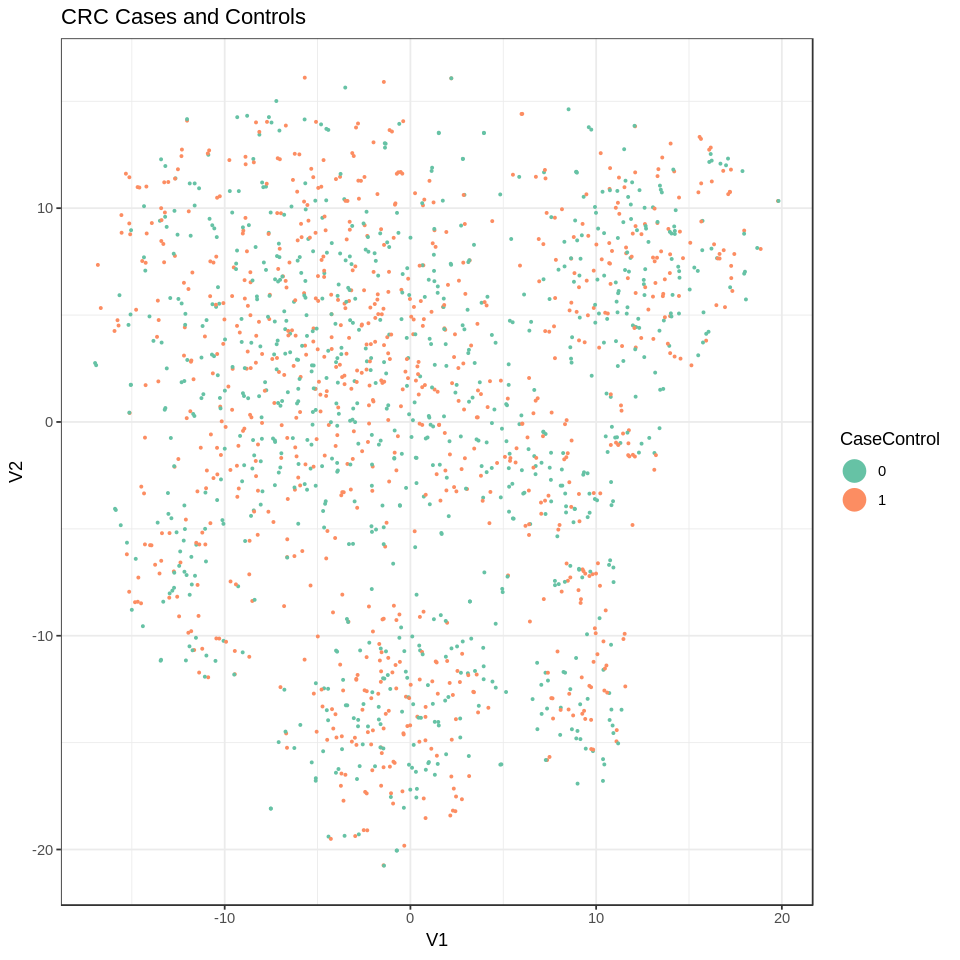

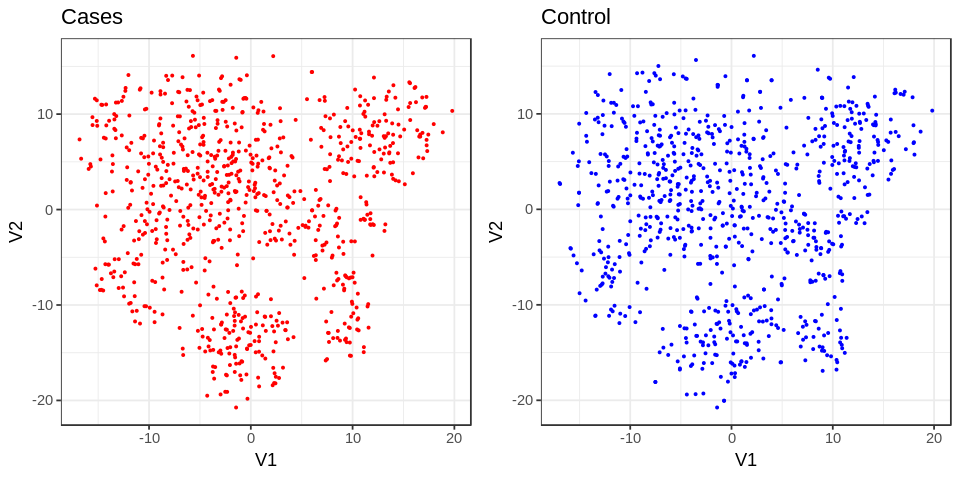

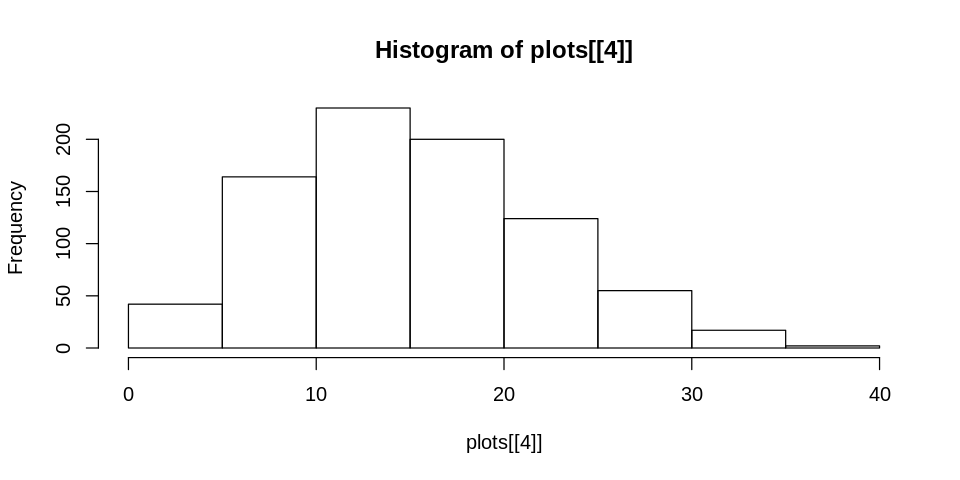

In [131]:
plots <- plot_tSNE_CANCER_Case_Control("CRC")
options(repr.plot.width=8, repr.plot.height=8)
plots[[1]]
options(repr.plot.width=8, repr.plot.height=4)
grid.arrange(plots[[2]], plots[[3]], ncol=2,nrow=1)
hist(plots[[4]])

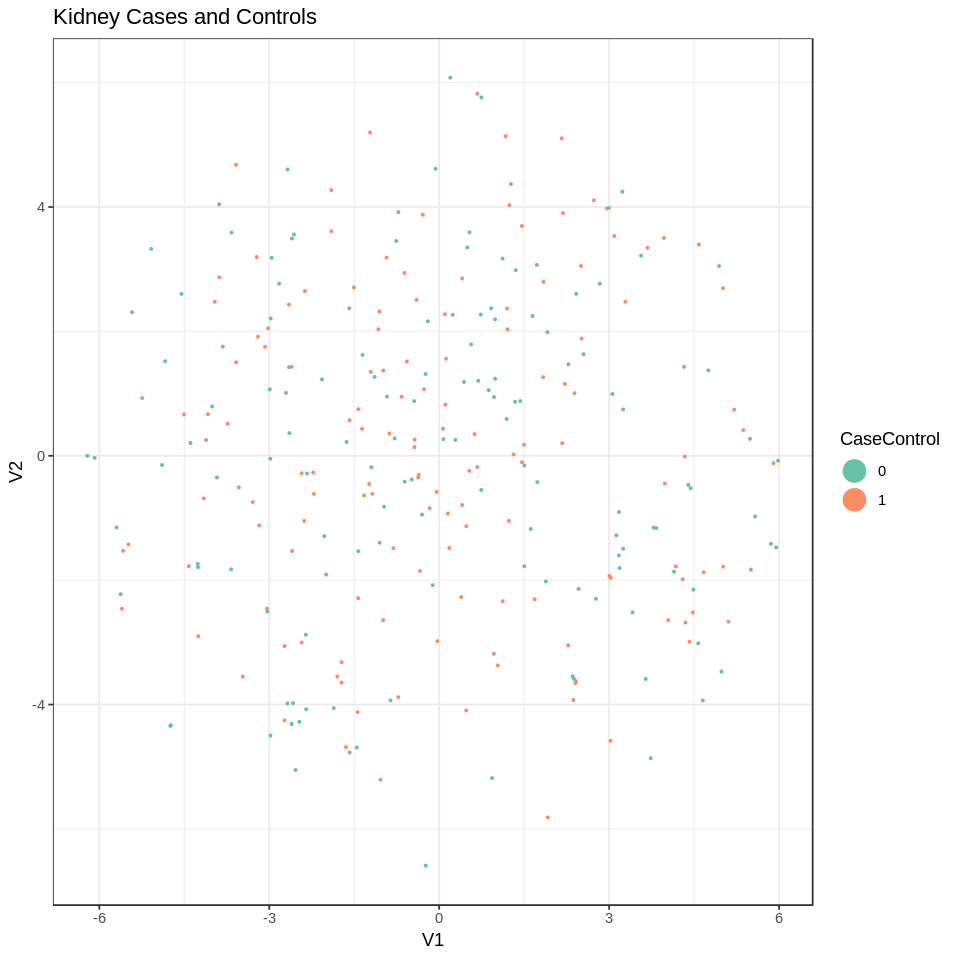

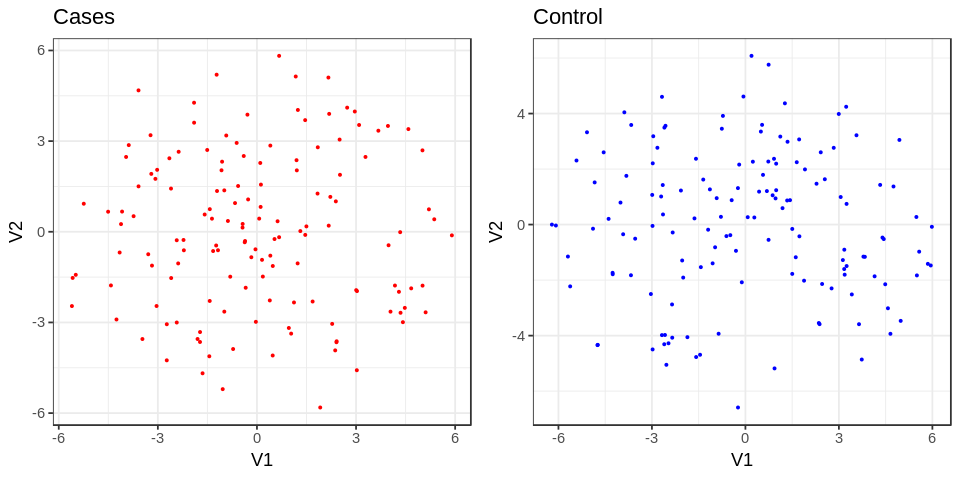

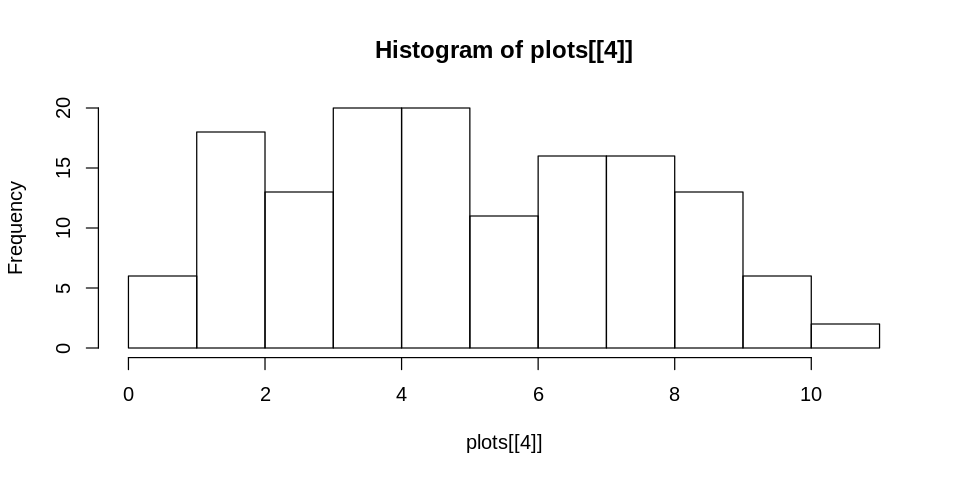

In [132]:
plots <- plot_tSNE_CANCER_Case_Control("Kidney")
options(repr.plot.width=8, repr.plot.height=8)
plots[[1]]
options(repr.plot.width=8, repr.plot.height=4)
grid.arrange(plots[[2]], plots[[3]], ncol=2,nrow=1)
hist(plots[[4]])

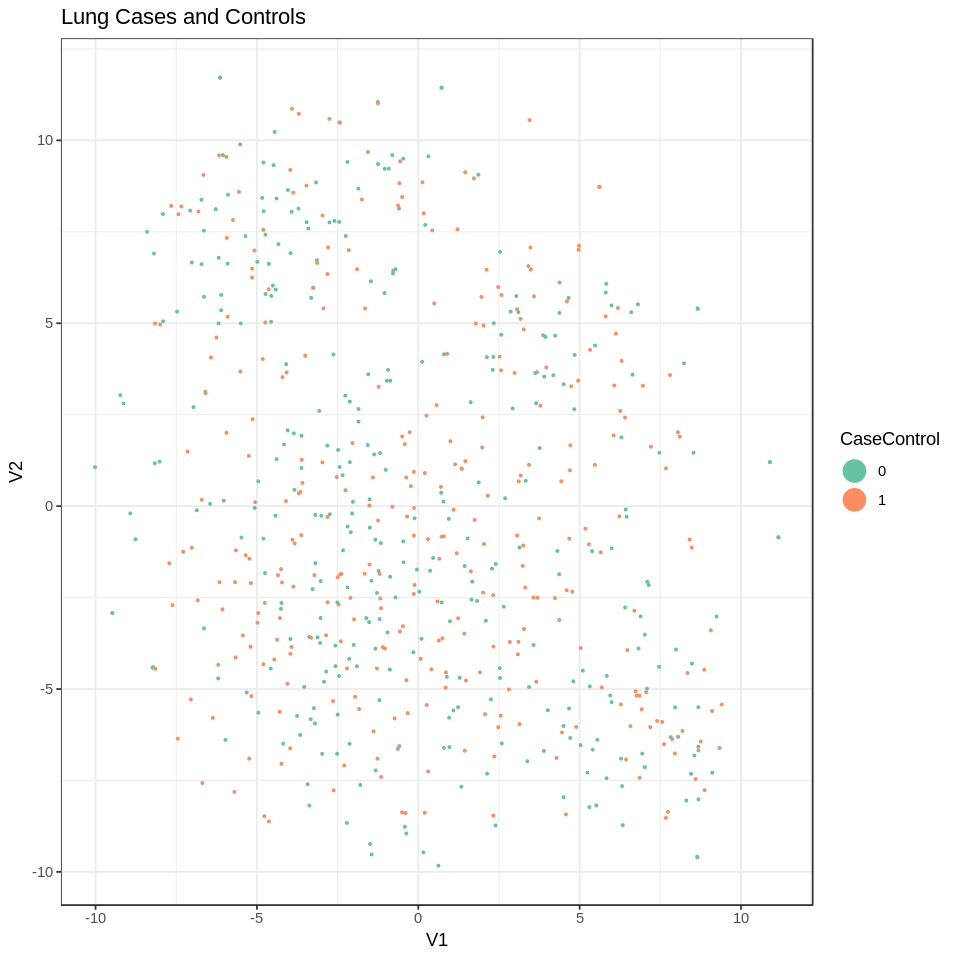

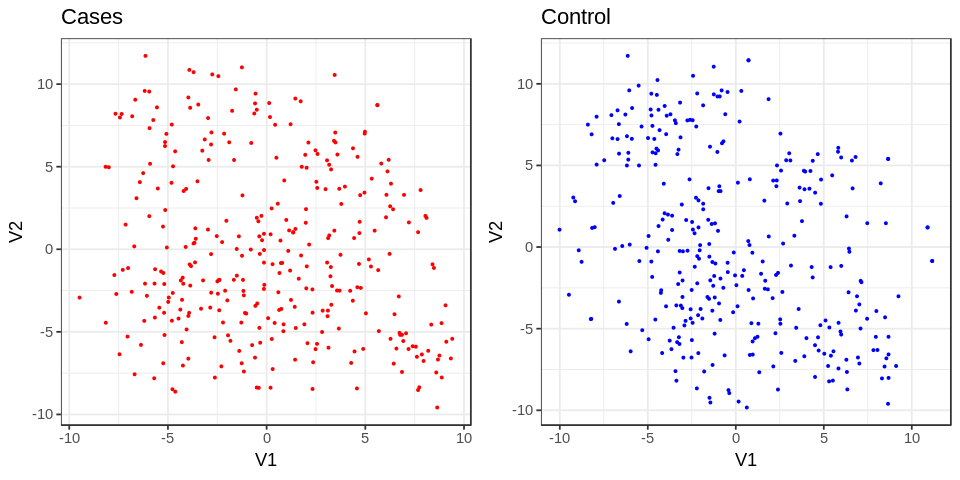

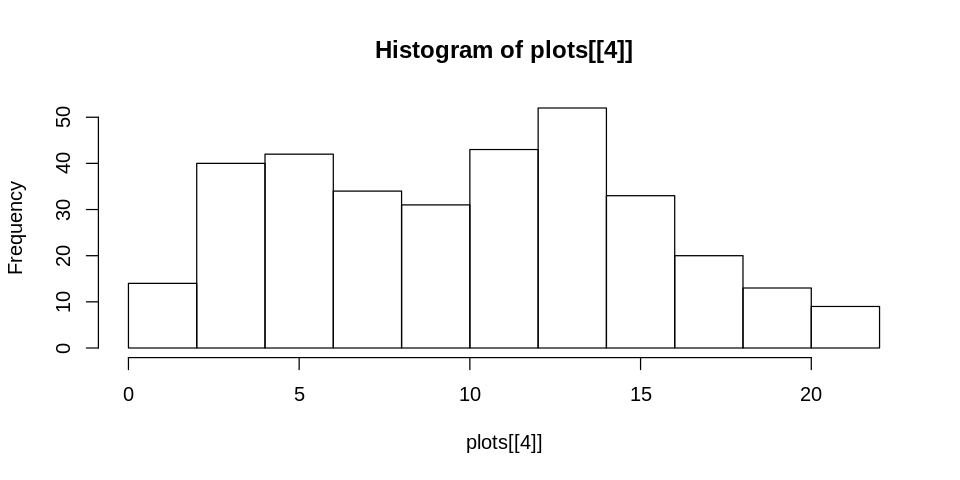

In [136]:
plots <- plot_tSNE_CANCER_Case_Control("Lung")
options(repr.plot.width=8, repr.plot.height=8)
plots[[1]]
options(repr.plot.width=8, repr.plot.height=4)
grid.arrange(plots[[2]], plots[[3]], ncol=2,nrow=1)
hist(plots[[4]])

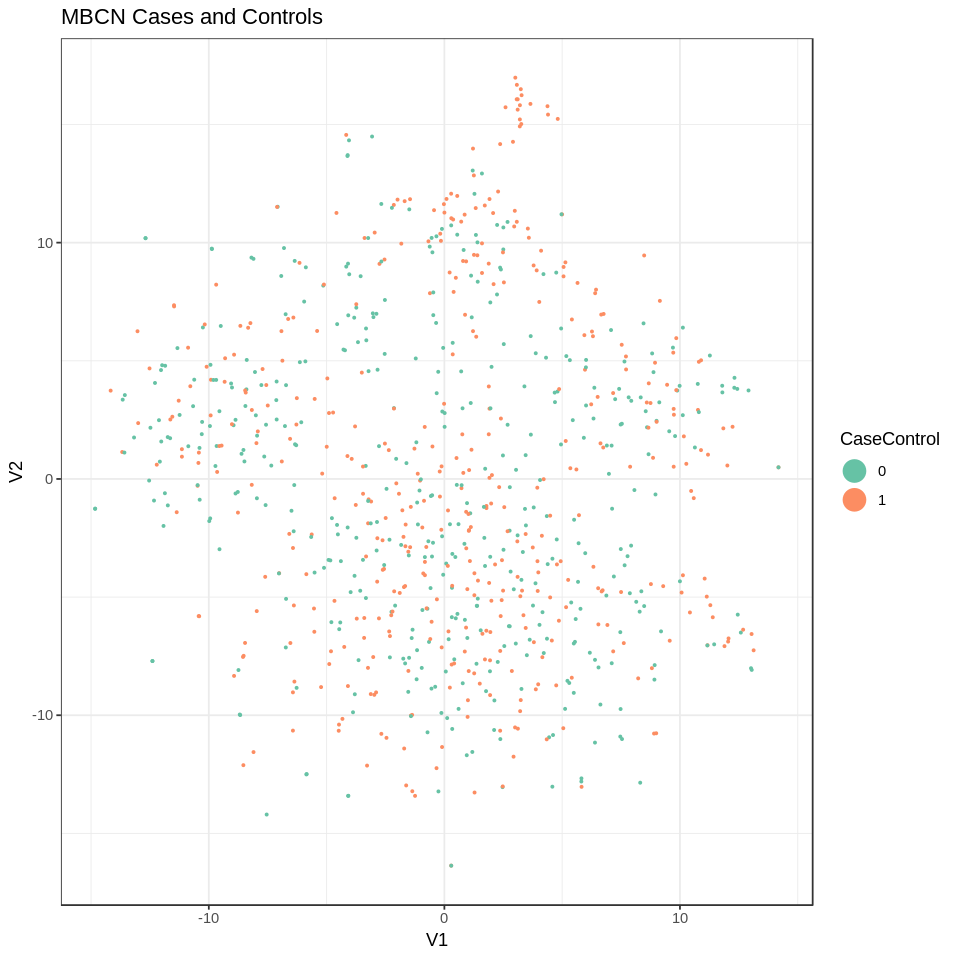

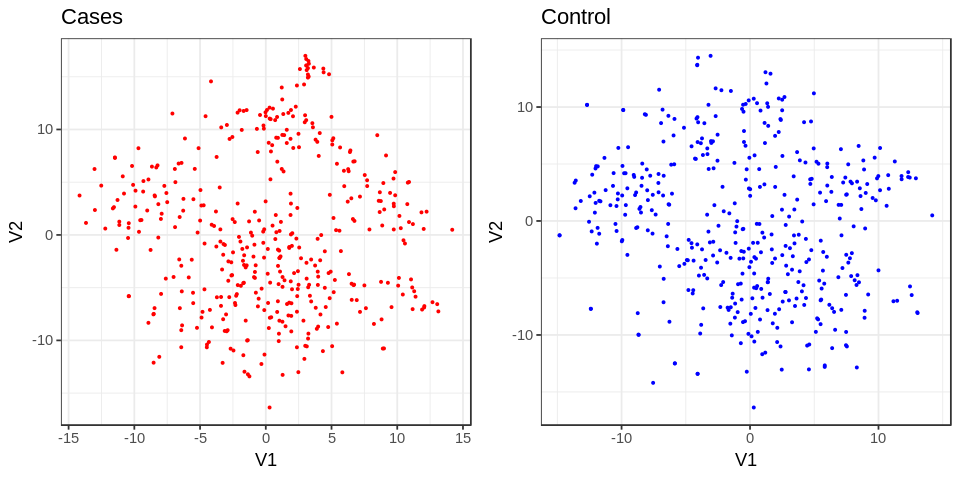

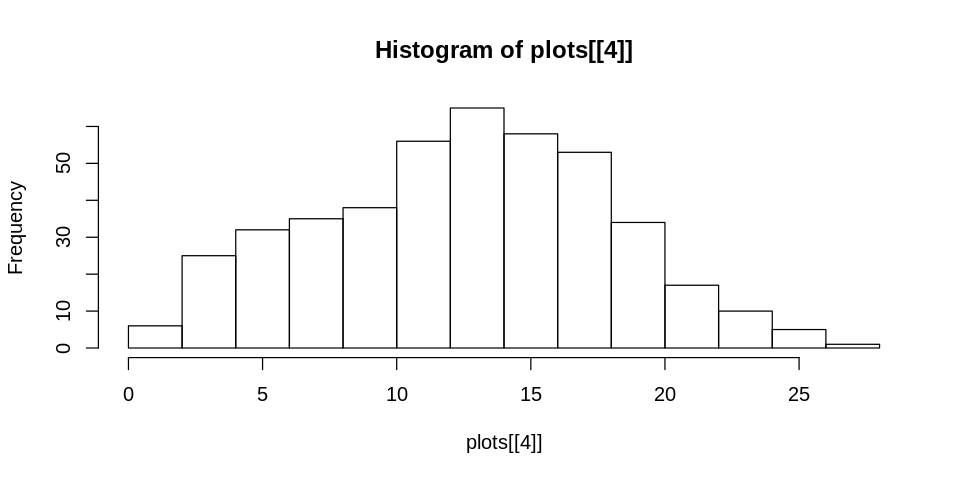

In [134]:
plots <- plot_tSNE_CANCER_Case_Control("MBCN")
options(repr.plot.width=8, repr.plot.height=8)
plots[[1]]
options(repr.plot.width=8, repr.plot.height=4)
grid.arrange(plots[[2]], plots[[3]], ncol=2,nrow=1)
hist(plots[[4]])

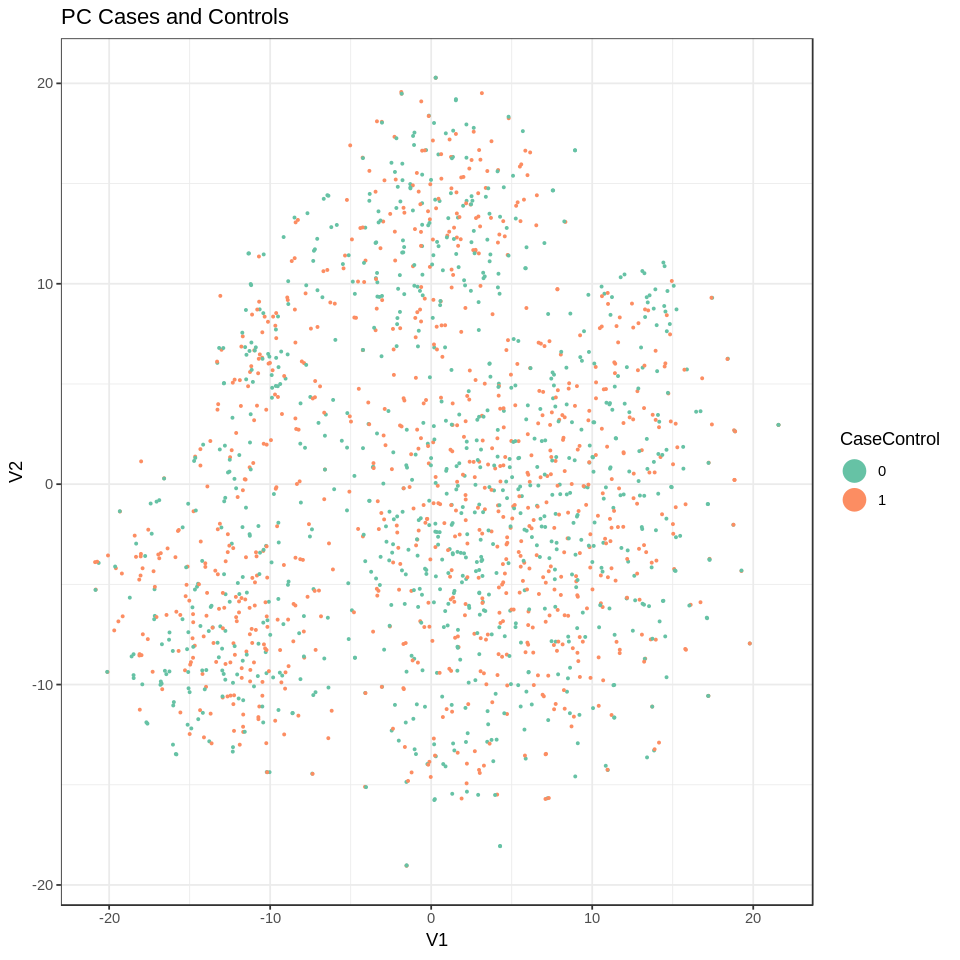

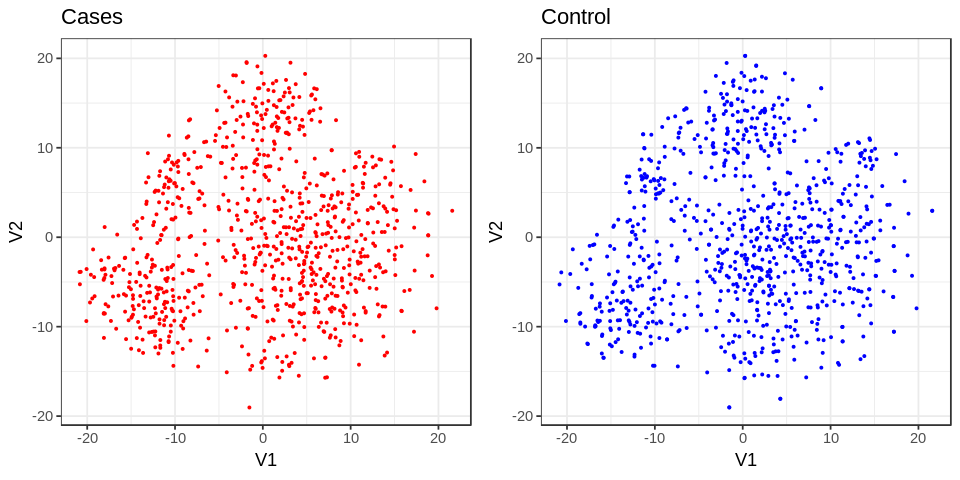

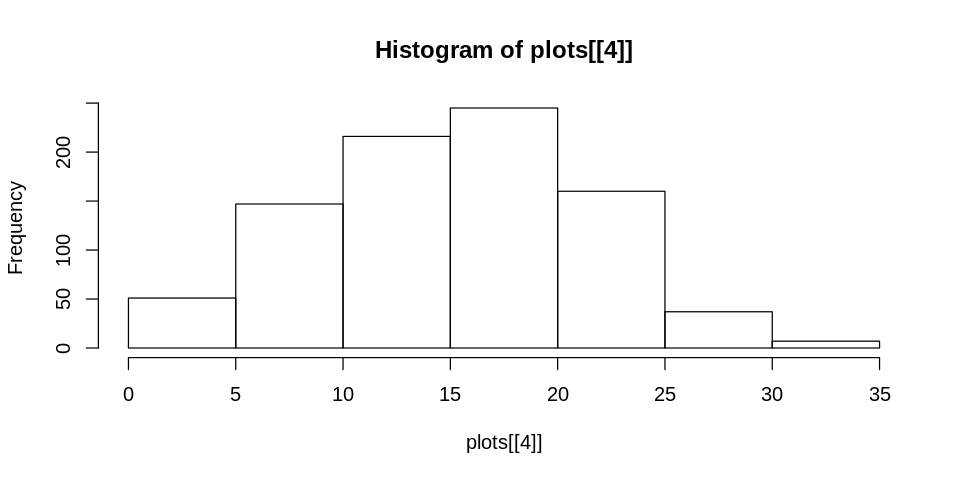

In [137]:
plots <- plot_tSNE_CANCER_Case_Control("PC")
options(repr.plot.width=8, repr.plot.height=8)
plots[[1]]
options(repr.plot.width=8, repr.plot.height=4)
grid.arrange(plots[[2]], plots[[3]], ncol=2,nrow=1)
hist(plots[[4]])

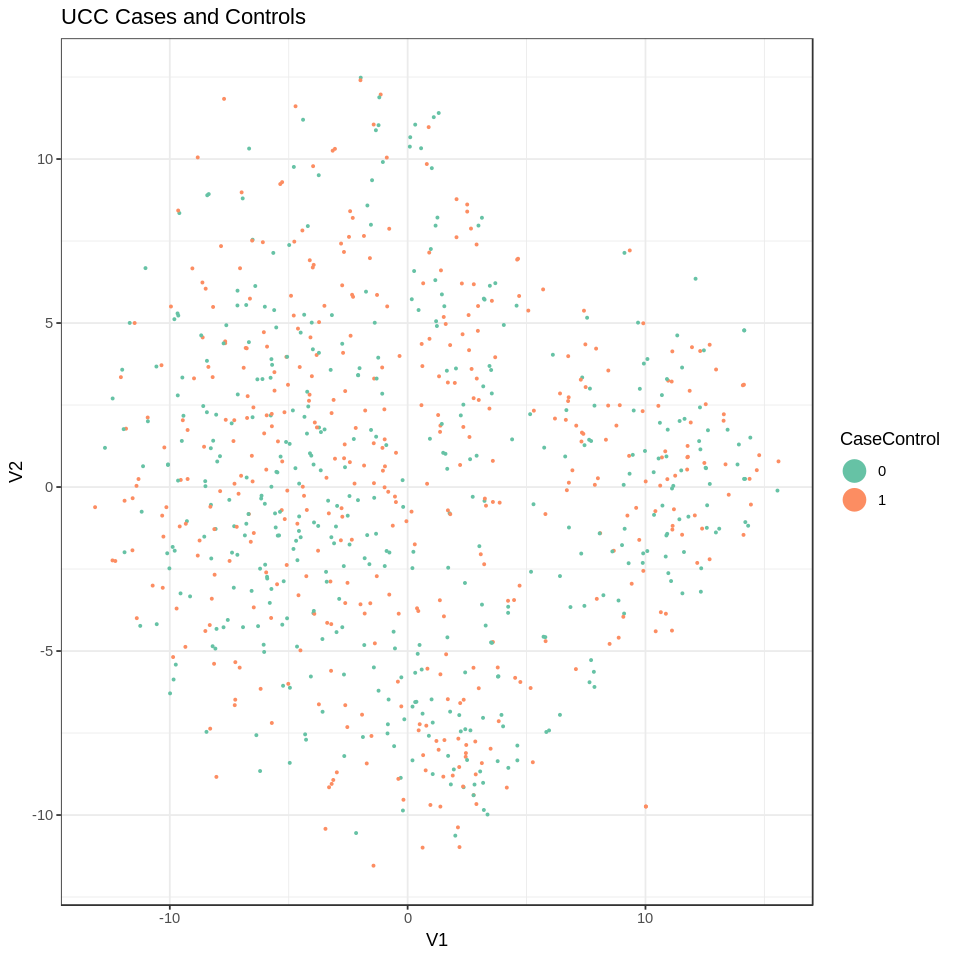

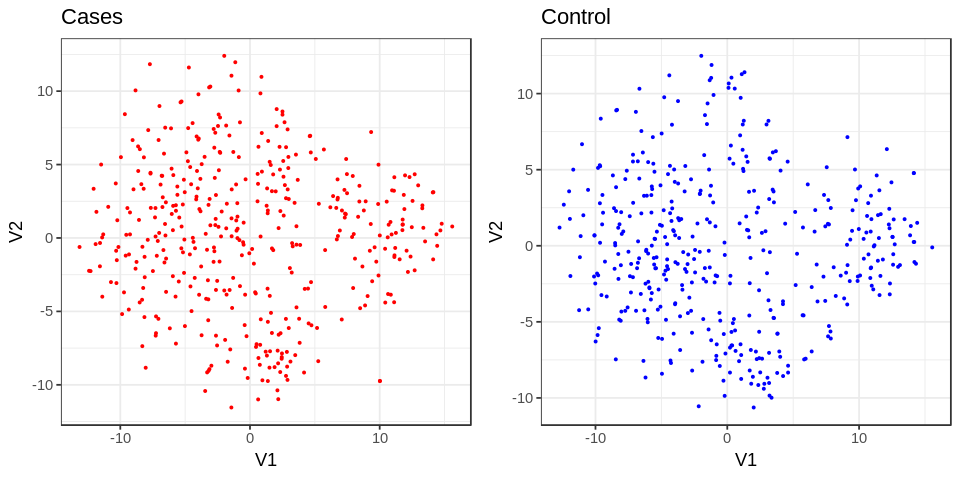

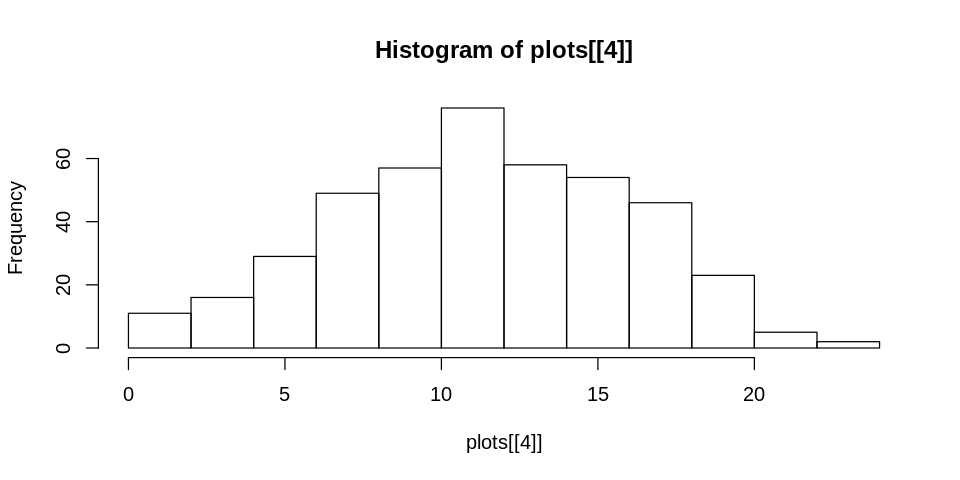

In [135]:
plots <- plot_tSNE_CANCER_Case_Control("UCC")
options(repr.plot.width=8, repr.plot.height=8)
plots[[1]]
options(repr.plot.width=8, repr.plot.height=4)
grid.arrange(plots[[2]], plots[[3]], ncol=2,nrow=1)
hist(plots[[4]])